In [1]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os
import io

from pathlib import Path

In [2]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [3]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [8]:
bucketName = "kvs-rekognition"

imageName = "car-img_000.jpg"

In [9]:
def detect_labels(bucket, key):
    response = rekognition.detect_labels(Image={"S3Object": {"Bucket": bucket, "Name": key}})

In [10]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

In [11]:
flaggedObjects = ["Car"]

for label in detectLabelsResponse["Labels"]:
    if(label["Name"] in flaggedObjects):
        print("Detected unsafe object:")
        print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))
        print("  - Parents: {}".format(label["Parents"]))

Detected unsafe object:
- Car (Confidence: 99.48031616210938)
  - Parents: [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]


In [12]:
# Define a function that will display image with bounded boxes around recognized objects
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)
                    # bucket name, saving image name, original image name (key)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "JPG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

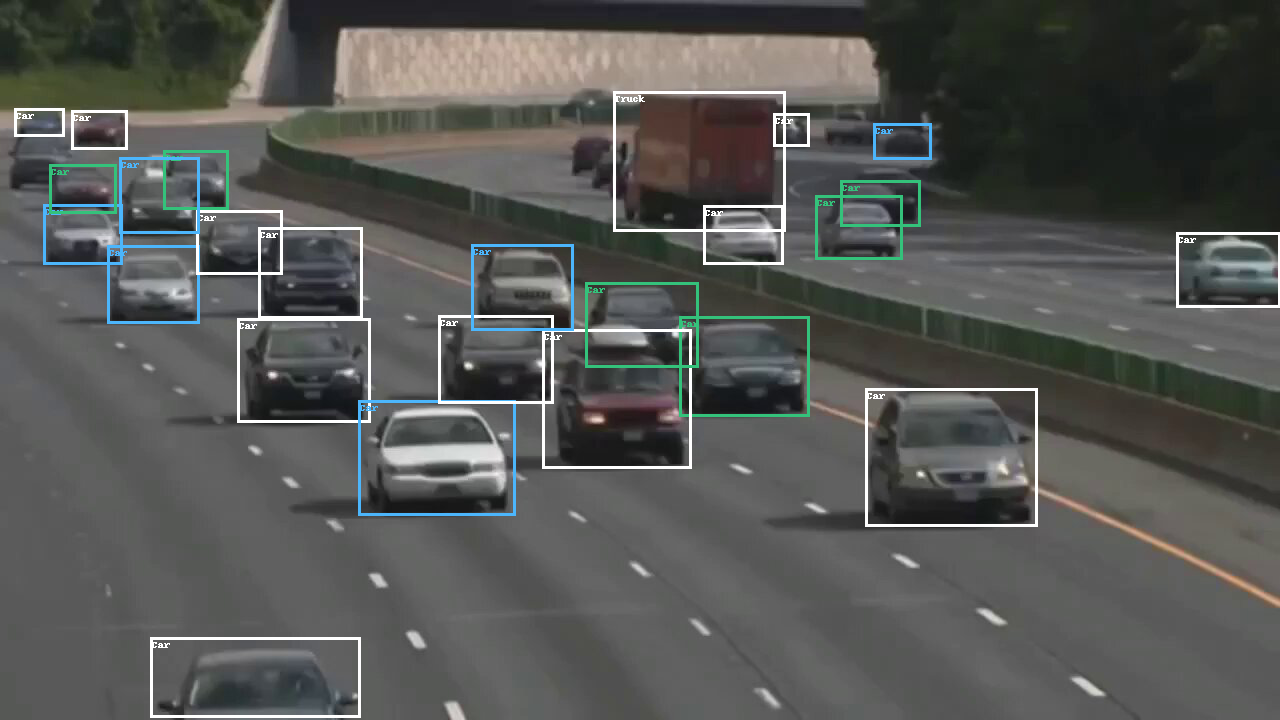

In [13]:
# Show image and bounded boxes around detected objects
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)

In [14]:
# Upload file to S3

s3 = boto3.client('s3')

s3.upload_file(
    Filename=imageName,
    Bucket=bucketName,
    Key="car-img" + "-bb.jpg",
)